In [ ]:
# %cd /kaggle/working
# !git clone https://github.com/TAYDOVAT/Cuoi_Ki_DL.git
# %cd /kaggle/working/Cuoi_Ki_DL

# !rm -r /kaggle/working/Cuoi_Ki_DL/test
# !rm -r /kaggle/working/Cuoi_Ki_DL/train
# !rm -r /kaggle/working/Cuoi_Ki_DL/val

# !cp -r "/kaggle/input/anh-ve-tinh/Ảnh vệ tinh/test" /kaggle/working/Cuoi_Ki_DL
# !cp -r "/kaggle/input/anh-ve-tinh/Ảnh vệ tinh/train" /kaggle/working/Cuoi_Ki_DL
# !cp -r "/kaggle/input/anh-ve-tinh/Ảnh vệ tinh/val" /kaggle/working/Cuoi_Ki_DL

# Train SRResNet x4

In [11]:
import os
import random
import torch
from pathlib import Path
from torch import optim
from torch.optim import lr_scheduler
from tqdm.auto import tqdm
from IPython.display import clear_output

from data import build_loader
from model import SRResNet
from losses import PixelLoss
from engine import train_srresnet_epoch, val_srresnet_epoch
from vis import show_lr_sr_hr, plot_curves


In [12]:
# Config override here
cfg = {
    'scale': 4,
    'hr_crop': 128,
    'train': {
        'batch_size': 16,
        'num_workers': 4,
        'epochs': 100,
        'lr': 1e-4,
    },
    'paths': {
        'train_lr': 'train/train_lr',
        'train_hr': 'train/train_hr',
        'val_lr': 'val/val_lr',
        'val_hr': 'val/val_hr',
        'test_lr': 'test/test_lr',
        'test_hr': 'test/test_hr',
    },
}
base_dir = None
cwd = Path.cwd().resolve()
for parent in [cwd] + list(cwd.parents):
    if (parent / 'train' / 'train_lr').is_dir():
        base_dir = parent
        break

if base_dir is None:
    raise FileNotFoundError(f"Cannot find 'train/train_lr' from cwd: {cwd}")

cfg['paths']['train_lr'] = str(base_dir / 'train' / 'train_lr')
cfg['paths']['train_hr'] = str(base_dir / 'train' / 'train_hr')
cfg['paths']['val_lr'] = str(base_dir / 'val' / 'val_lr')
cfg['paths']['val_hr'] = str(base_dir / 'val' / 'val_hr')
cfg['paths']['test_lr'] = str(base_dir / 'test' / 'test_lr')
cfg['paths']['test_hr'] = str(base_dir / 'test' / 'test_hr')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.makedirs('weights', exist_ok=True)


In [13]:
train_dataset, train_loader = build_loader(
    cfg['paths']['train_lr'], cfg['paths']['train_hr'],
    scale=cfg['scale'], hr_crop=cfg['hr_crop'],
    batch_size=cfg['train']['batch_size'],
    num_workers=cfg['train']['num_workers'],
    train=True
)
val_dataset, val_loader = build_loader(
    cfg['paths']['val_lr'], cfg['paths']['val_hr'],
    scale=cfg['scale'], hr_crop=cfg['hr_crop'],
    batch_size=1,
    num_workers=cfg['train']['num_workers'],
    train=False
)


In [14]:
generator = SRResNet(scale=cfg['scale']).to(device)
optimizer = optim.Adam(generator.parameters(), lr=cfg['train']['lr'])
scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
pixel_criterion = PixelLoss().to(device)


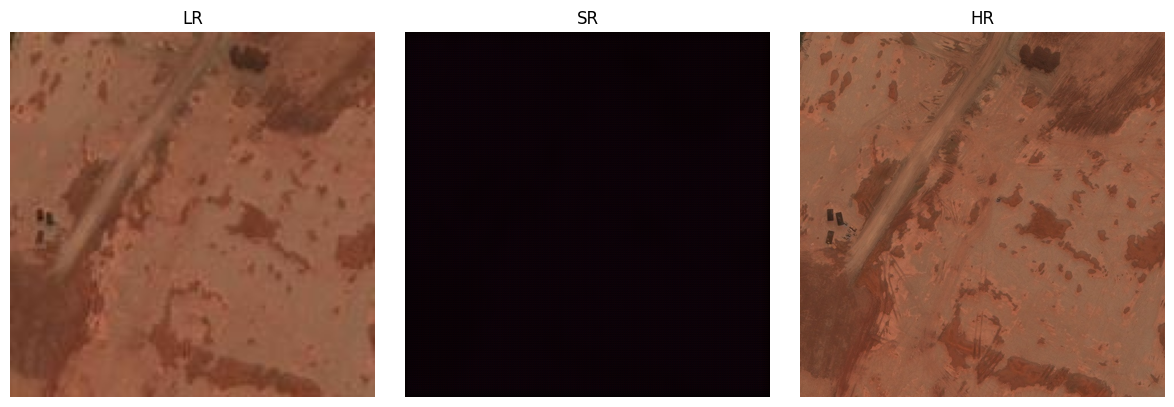

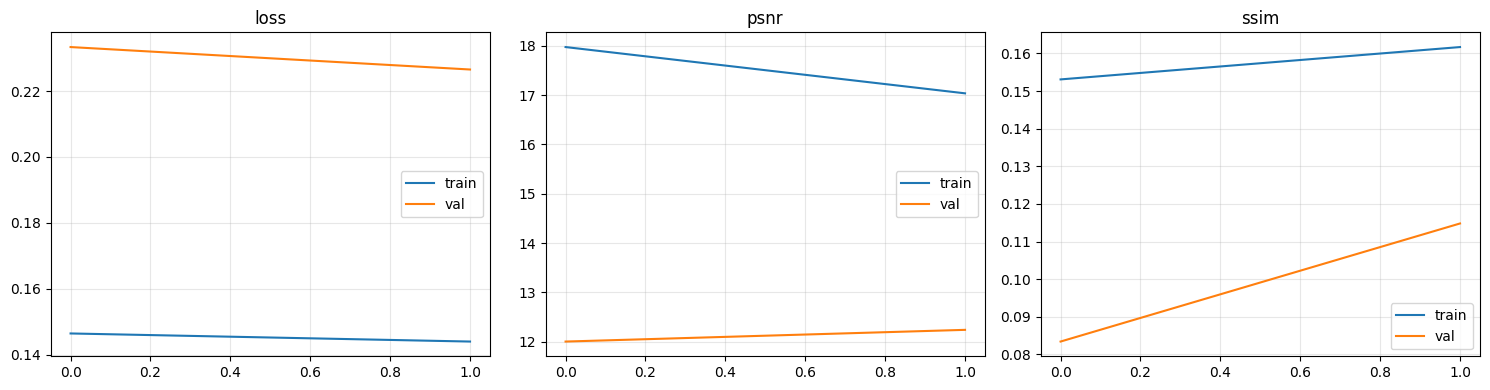

Epoch 3/100 [Val]:  80%|████████  | 4/5 [01:16<00:15, 15.76s/it, loss=0.1304, psnr=12.25]

In [ ]:
history = {
    'loss': {'train': [], 'val': []},
    'psnr': {'train': [], 'val': []},
    'ssim': {'train': [], 'val': []},
}
best_psnr = -1.0
epochs = cfg['train']['epochs']

for epoch in range(1, epochs + 1):
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{epochs} [Train]')
    train_stats = train_srresnet_epoch(generator, train_pbar, optimizer, device, pixel_criterion)

    val_pbar = tqdm(val_loader, desc=f'Epoch {epoch}/{epochs} [Val]')
    val_stats = val_srresnet_epoch(generator, val_pbar, device, pixel_criterion)

    scheduler.step()

    history['loss']['train'].append(train_stats['loss'])
    history['loss']['val'].append(val_stats['loss'])
    history['psnr']['train'].append(train_stats['psnr'])
    history['psnr']['val'].append(val_stats['psnr'])
    history['ssim']['train'].append(train_stats['ssim'])
    history['ssim']['val'].append(val_stats['ssim'])

    torch.save(generator.state_dict(), 'weights/last_srresnet.pth')
    if val_stats['psnr'] > best_psnr:
        best_psnr = val_stats['psnr']
        torch.save(generator.state_dict(), 'weights/best_srresnet.pth')

    clear_output(wait=True)

    # Random sample visualization
    rand_idx = random.randint(0, len(val_dataset) - 1)
    lr_sample, hr_sample = val_dataset[rand_idx]
    lr_in = lr_sample.unsqueeze(0).to(device)
    with torch.no_grad():
        sr_sample = generator(lr_in).cpu()
    show_lr_sr_hr(lr_sample, sr_sample, hr_sample)

    # Curves
    plot_curves(history)
